# Importing packages

In [16]:
import torch
from torch import nn
import torch.nn.functional as F
import functools
import operator
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Data preprocessing

In [17]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


class SignsLanguageDataset(Dataset):
    
    def __init__(self, mode = "", transform = None):
        
        self.mode = mode
        self.transform = transform
        
        if self.mode == "train":
            # you should adjust the data path
            self.signs_lang_dataset = pd.read_csv('/disk/vanishing_data/rt678/cnn/data/mnist-sign-language/data/sign_mnist_train.csv')
            # you should adjust the data path 
            self.X_set = self.signs_lang_dataset.iloc[:22455, 1:].values.reshape(-1, 28, 28, 1) # toTensor expects (HxWxC) and transforms it to (CxHxW) !!!
            self.y_set = self.signs_lang_dataset.iloc[:, 0].values
        elif self.mode == "valid":
            # you should adjust the data path 
            self.signs_lang_dataset = pd.read_csv('/disk/vanishing_data/rt678/cnn/data/mnist-sign-language/data/sign_mnist_train.csv')
            self.X_set = self.signs_lang_dataset.iloc[22455:, 1:].values.reshape(-1，28, 28，1)
            self.y_set = self.signs_lang_dataset.iloc[22455:, 0].values
        else:
            self.signs_lang_dataset = pd.read_csv('/disk/vanishing_data/rt678/cnn/data/mnist-sign-language/data/sign_mnist_test.csv')
            self.X_set = self.signs_lang_dataset.iloc[:, 1:].values.reshape(-1, 28, 28, 1)
            self.y_set = self.signs_lang_dataset.iloc[:, 0].values         

        
    def __getitem__(self, index):
        
        image = self.X_set[index].astype(np.float32)
        
        label = self.y_set[index]
        
        if self.transform:
            image = self.transform(image)
        
        sample = {'image_sign': image, 'label': label}

        return sample
        
    def __len__(self):
        return self.X_set.__len__()

    
    
transform_train = transforms.Compose([
    
    transforms.ToPILImage(),
    transforms.Resize(36),
    transforms.RandomHorizontalFlip(p=0.8),
    transforms.RandomRotation(45),
    transforms.CenterCrop(size=(28,28))
    transforms.ToTensor(),
    
    ])



transform_test = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(p=0.8),
    transforms.RandomRotation(45),
    transforms.ToTensor(),
    
])
    # apply more transformation like on the list !!! maybe padding, zoom_range (0.1), width-shift-range, height-shift range 

SyntaxError: invalid character in identifier (<ipython-input-17-de5e0380a53d>, line 27)

In [12]:
# dataset_train with transform
dataset_train_1 = SignsLanguageDataset(mode = "train", transform = transform_train)
train_loader_1 = torch.utils.data.DataLoader(dataset = dataset_train_1, batch_size = 128，shuffle=True)

# dataset_train without transform
dataset_train_2 = SignsLanguageDataset(mode = "train",transform = False)
train_loader_2 = torch.utils.data.DataLoader(dataset = dataset_train_2, batch_size = 128，shuffle=True)

dataset_valid = SignsLanguageDataset(mode = "validate",transform = False)
valid_loader = torch.utils.data.DataLoader(dataset = dataset_valid, batch_size = 128，shuffle=True)

# dataset_test with transform
dataset_test_1 = SignsLanguageDataset(mode = "test",transform = transform_test)
test_loader_1 = torch.utils.data.DataLoader(dataset = dataset_test_1, batch_size = 128，shuffle=True)

# dataset_test without transform
dataset_test_2 = SignsLanguageDataset(mode = "test",transform = False)
test_loader_2 = torch.utils.data.DataLoader(dataset = dataset_test_2, batch_size = 128，shuffle=True)


SyntaxError: invalid character in identifier (<ipython-input-12-f54aae2f31e4>, line 3)


# Get available device and create CNN model


In [14]:
# Get the available device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
    
    
#$cnn_model = CNN().to(device)
# cnn_model = CNN().to(device)
# print(cnn_model)

cpu


# General help methods for creating multiple models for finding suitable hyperparameter

In [7]:
def conv_nxn(in_planes: int, out_planes: int, kernel_size: int) -> nn.Conv2d:
    """nxn convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size)

def fc_layer(in_planes: int, out_planes: int) -> nn.Linear:
    """ fully connected layer """
    return nn.Linear(in_planes, out_planes)

def relu(inplace=True) -> nn.ReLU:
    """ activation function """
    return nn.ReLU()

def max_pool(kernel: int) -> nn.MaxPool2d:
    """max_pooling layer"""
    return nn.MaxPool2d(kernel)

def batch_norm(planes: int) -> nn.BatchNorm2d:
    """ batch normalization layer"""
    return nn.BatchNorm2d(planes)

def dropout(percentage: float) -> nn.Dropout:
    """ dropout layer"""
    return nn.Dropout(percentage)

def log_softmax() -> nn.LogSoftmax:
    """ softmax distribution on the output layer """
    return nn.LogSoftmax(dim = 1)

class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)


class CNN_Model(nn.Module): 
    
    def __init__(self, number_conv_layers, num_fc_layers, conv_in_planes, conv_out_planes, fc_in_planes, fc_out_planes, num_classes=25, input_dims=(1, 28, 28)): 
        super().__init__()
    
        feature_extractor = []
        feature_extractor.append(conv_nxn(conv_in_planes, conv_out_planes, 3))
        feature_extractor.append(batch_norm(conv_out_planes))
        feature_extractor.append(relu(inplace=True))
        feature_extractor.append(max_pool(kernel=2))
        feature_extractor.append(dropout(0.5))
        for i in range(1, number_conv_layers):
            feature_extractor.append(conv_nxn(conv_out_planes, conv_out_planes * 2, 5))
            feature_extractor.append(batch_norm(conv_out_planes * 2))
            feature_extractor.append(relu(inplace=True))
            feature_extractor.append(max_pool(kernel=2))
            feature_extractor.append(dropout(0.5))
            conv_out_planes *= 2


        self.feature_extractor = nn.Sequential(*feature_extractor)
        num_features_before_fcnn = functools.reduce(operator.mul, list(self.feature_extractor(torch.rand(1, *input_dims)).shape))


        classifier = []
        classifier.append(fc_layer(num_features_before_fcnn, fc_out_planes))
        classifier.append(nn.ReLU(inplace=True))
        classifier.append(dropout(0.5))
        for i in range(1, num_fc_layers-1):
            classifier.append(fc_layer(fc_out_planes, fc_out_planes))
            classifier.append(nn.ReLU(inplace=True))
            classifier.append(dropout(0.5))

        classifier.append(nn.Linear(fc_out_planes, num_classes))
        classifier.append(nn.LogSoftmax(dim = 1))
        
        self.classifier = nn.Sequential(*classifier)
    
    def forward(self, x):
        size = x.size(0)
        out = self.feature_extractor(x)
        out = out.view(size, -1)
        out = self.classifier(out)
        return out


# Training and testing phases

In [23]:
def train(cnn_model): 

    running_loss_history = []
    val_running_loss_history = []
    test_loss_history = []

    torch.manual_seed(1111)
            
    num_epochs = 100
    learning_rate = 0.001

    cnn_model.train()
    cnn_model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(cnn_model.parameters(), lr=learning_rate)

    # Train the model
    total_step = len(train_loader)

    for epoch in range(num_epochs):
        
        running_loss = 0.0
        val_running_loss = 0.0
        
        for i, data in enumerate(train_loader):
            
            images = data['image_sign'].type(torch.FloatTensor).to(device)
            labels = data['label'].type(torch.LongTensor).to(device)
            
            # Forward pass
            outputs = cnn_model(images)
            loss = criterion(outputs, labels)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
            if (i+1) % 100 == 0:
                pass
                # print ("Epoch [{}/{}], Step [{}/{}], Training Loss: {:.4f}"
                #     .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        else:
            # Evaluate the current model on validation data
            correct = 0
            total = 0 # accumulated loss over mini-batches
            with torch.no_grad():
                for data in valid_loader:
                    images = data['image_sign'].type(torch.FloatTensor).to(device)
                    labels = data['label'].type(torch.LongTensor).to(device)
                    outputs = cnn_model(images)
                    val_loss = criterion(outputs, labels)
                    _, predicts = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicts == labels).sum()
                    val_running_loss += val_loss.item()
                    
            # Report the loss on validation data
            #print ("\nEpoch [{}], Validation Loss: {:.4f}"
                    #.format(epoch+1, val_loss))
            #print ("=======================================")
            
            epoch_loss = running_loss/len(train_loader)
            running_loss_history.append(epoch_loss)
            val_epoch_loss = val_running_loss/len(valid_loader)
            val_running_loss_history.append(val_epoch_loss)
      
    # Report the accuracy on the validation data after the last epoch - this time we take them as the test data   
    #print('Accuracy on the test data: %d %%' % (100 * correct / total))
        
    # Save the model checkpoint to storage/ of Gradient (free persistent storage)
    #torch.save(net.state_dict(), 'storage/resnet.pth')
    #torch.save(net, 'storage/resnet.ckpt')

    return running_loss_history, val_running_loss_history


In [9]:
""" Test method """
def test(cnn_model):
    correct = 0
    total = 0 # accumulated loss over mini-batches
    test_running_loss = 0.0
    #test_loss_history = []
    cnn_model.eval()
    cnn_model.to(device)
    criterion = nn.CrossEntropyLoss()

    # test on validation set
    with torch.no_grad():
        for data in valid_loader:
            images = data['image_sign'].type(torch.FloatTensor).to(device)
            labels = data['label'].type(torch.LongTensor).to(device)
            outputs = cnn_model(images)
            test_loss = criterion(outputs, labels)
            _, predicts = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicts == labels).sum()
            test_running_loss += test_loss.item()

    print('Accuracy on the validation data: %d %%' % (100 * correct.item() / total))

    correct = 0
    total = 0 # accumulated loss over mini-batches
    test_running_loss = 0.0
    # test on test set
    with torch.no_grad():
        for data in test_loader:
            images = data['image_sign'].type(torch.FloatTensor).to(device)
            labels = data['label'].type(torch.LongTensor).to(device)
            outputs = cnn_model(images)
            test_loss = criterion(outputs, labels)
            _, predicts = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicts == labels).sum()
            test_running_loss += test_loss.item()
    
    print('Accuracy on the test data: %d %%' % (100 * correct.item() / total))


In [13]:
# Best CNN model found SO FAR ! 
class CNN_Model(nn.Module): 
    
    def __init__(self, input_dims=(1,28,28)) :
        super(CNN_Model,self).__init__()
    
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),

            nn.Conv2d(32, 64, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),

            nn.Conv2d(64, 128, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25), 

            nn.Conv2d(128, 256, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25), 

        )

        num_features_before_fcnn = functools.reduce(operator.mul, list(self.feature_extractor(torch.rand(1, *(input_dims))).shape))
        # a trick to find out automatically the number of flattened features in the first fully connected layer since there is no flatten()-method like in Keras or Tensorflow

        self.classifier = nn.Sequential(
            nn.Linear(num_features_before_fcnn, 128),
            nn.ReLU(),
            nn.Dropout(0.5), 

            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.5),  

            nn.Linear(128, 25),
            nn.LogSoftmax(dim = 1)
        )
    
    def forward(self, x):
        size = x.size(0)
        out = self.feature_extractor(x)
        out = out.view(size, -1)
        out = self.classifier(out)
        return out


In [24]:
# train and test the model above

cnn_model = CNN_Model()

training_loss, validation_loss = train(cnn_model)



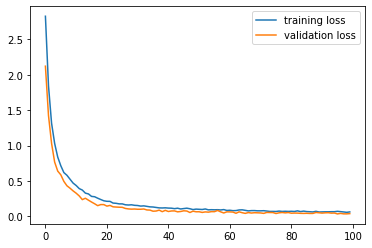

In [25]:
# Draw the losses
plt.plot(training_loss, label='training loss')
plt.plot(validation_loss, label='validation loss')
plt.legend()

In [26]:
# test the model

test(cnn_model)

Accuracy on the validation data: 100 %
Accuracy on the test data: 99 %


# THE STUFFT MENTIONED BELOW IS TO FIND AFTER A GOOD ARCHITECTURE IS found, so try it after you have a suitable model

# Find out which learning rate is the best

# What batch size to use

# which optimizer to use ? 

# Test the model on a separate data set never seen before

# Visualize the learned features after the model is trained